# Using a Modflow model as a stressmodel in Pastas

This notebook shows how to use a simple Modflow model as stress model in Pastas.

## Packages

In [1]:
import pandas as pd
import pastas as ps
from pastas.timer import SolveTimer

import pastas_plugins.modflow as ppmf

ps.set_log_level("ERROR")

  from .autonotebook import tqdm as notebook_tqdm



## Data

array([[<Axes: title={'center': 'head'}, xlabel='date'>],
       [<Axes: title={'center': 'rain'}, xlabel='date'>],
       [<Axes: title={'center': 'evap'}, xlabel='date'>]], dtype=object)

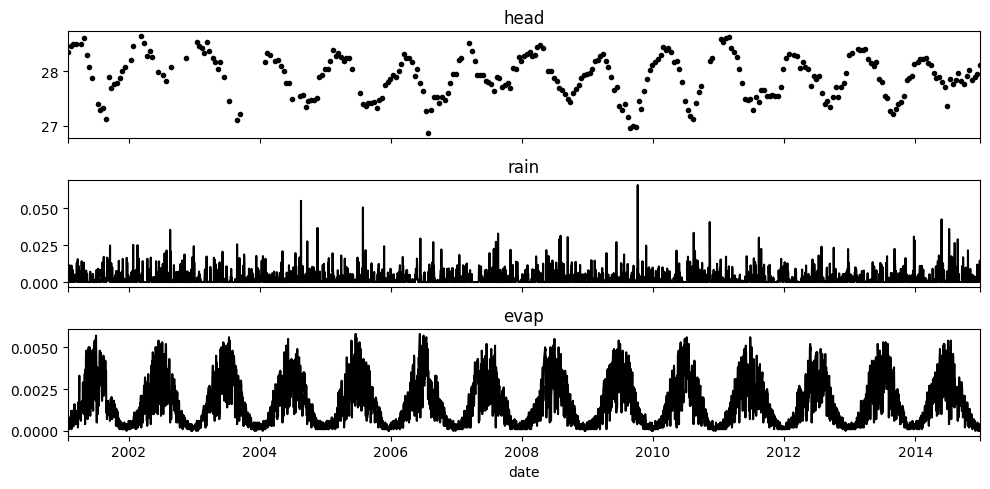

In [2]:
# %%
tmin = pd.Timestamp("2001-01-01")
tmax = pd.Timestamp("2014-12-31")

tmin_wu = tmin - pd.Timedelta(days=3651)
tmin_wu = pd.Timestamp("1986-01-01")

head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    )
    .squeeze()
    .loc[tmin:tmax]
)
prec = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
        index_col="date",
        parse_dates=True,
    )
    .squeeze()
    .loc[tmin_wu:tmax]
)
evap = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
        index_col="date",
        parse_dates=True,
    )
    .squeeze()
    .loc[tmin_wu:tmax]
)

mf6_exe = "bin/mf6"
ps.plots.series(head, [prec, evap], hist=False)

# Time series models

## Standard exponential model

Fit report head                   Fit Statistics
nfev    13                     EVP         93.50
nobs    295                    R2           0.94
noise   False                  RMSE         0.10
tmin    2001-01-28 00:00:00    AIC      -1365.20
tmax    2014-12-28 00:00:00    BIC      -1350.46
freq    D                      Obj          1.40
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal     initial  vary  stderr
test_exp_A  618.818683  219.247860  True  ±5.36%
test_exp_a  183.492840   10.000000  True  ±4.42%
test_exp_f   -1.618881   -1.000000  True  ±3.95%
constant_d   28.248544   27.903864  True  ±0.19%


<Axes: title={'center': 'Results of head'}, xlabel='date', ylabel='Groundwater levels [meter]'>

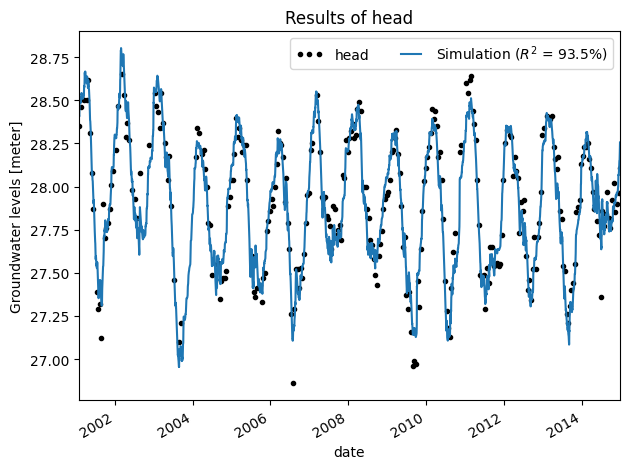

In [3]:
# %%
# create model with exponential response function
mlexp = ps.Model(head, noisemodel=False)
mlexp.add_stressmodel(
    ps.RechargeModel(prec=prec, evap=evap, rfunc=ps.Exponential(), name="test_exp")
)
mlexp.solve(tmin=tmin, tmax=tmax, noise=False)
mlexp.plot()

## Uncalibrated MODFLOW time series model

Using parameters from exponential model

In [12]:
# %%
# extract resistance and sy from exponential model
# transform exponential parameters to modflow resistance and sy
mlexp_c = mlexp.parameters.loc["test_exp_A", "optimal"]
mlexp_c_i = mlexp.parameters.loc["test_exp_A", "initial"]
mlexp_sy = (
    mlexp.parameters.loc["test_exp_a", "optimal"]
    / mlexp.parameters.loc["test_exp_A", "optimal"]
)
mlexp_sy_i = (
    mlexp.parameters.loc["test_exp_a", "initial"]
    / mlexp.parameters.loc["test_exp_A", "initial"]
)
mlexp_d = mlexp.parameters.loc["constant_d", "optimal"]
mlexp_d_i = mlexp.parameters.loc["constant_d", "initial"]
mlexp_f = mlexp.parameters.loc["test_exp_f", "optimal"]
mlexp_f_i = mlexp.parameters.loc["test_exp_f", "initial"]

<Axes: title={'center': 'Results of head'}, xlabel='date', ylabel='Groundwater levels [meter]'>

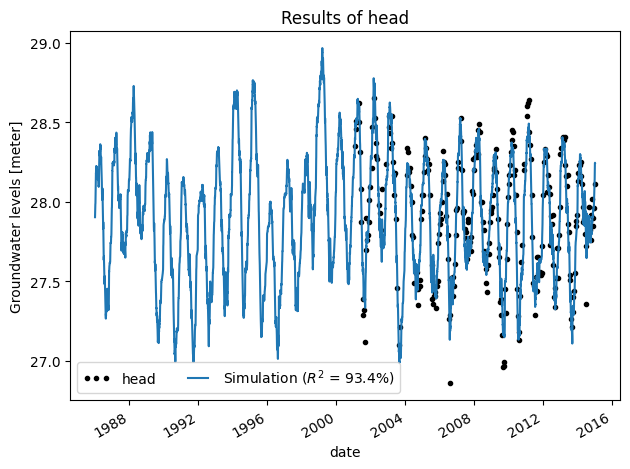

In [5]:
# %%
# create modflow pastas model with c and sy
mlexpmf = ps.Model(head, noisemodel=False)
expmf = ppmf.ModflowRch(exe_name=mf6_exe, sim_ws="mf_files/test_expmf")
expsm = ppmf.ModflowModel([prec, evap], modflow=expmf, name="test_expmfsm")
mlexpmf.add_stressmodel(expsm)
mlexpmf.set_parameter(f"{expsm.name}_sy", initial=mlexp_sy, vary=False)
mlexpmf.set_parameter(f"{expsm.name}_c", initial=mlexp_c, vary=False)
mlexpmf.set_parameter(f"{expsm.name}_f", initial=mlexp_f, vary=False)
mlexpmf.set_parameter("constant_d", initial=mlexp_d, vary=False)
# mlexpmf.solve(noise=False)
mlexpmf.plot()

## Calibrated MODFLOW time series model

In [6]:
# %%
ml = ps.Model(head, constant=True, noisemodel=False)
mf = ppmf.ModflowRch(exe_name=mf6_exe, sim_ws="mf_files/test_mfrch")
sm = ppmf.ModflowModel([prec, evap], modflow=mf, name="test_mfsm")
ml.add_stressmodel(sm)
ml.set_parameter(f"{sm.name}_sy", initial=mlexp_sy_i, vary=True)
ml.set_parameter(f"{sm.name}_c", initial=mlexp_c_i, vary=True)
ml.set_parameter(f"{sm.name}_f", initial=mlexp_f_i, vary=True)
ml.set_parameter("constant_d", initial=mlexp_d_i, vary=True)
solver = ps.LeastSquares(method="lm")
with SolveTimer() as st:
    ml.solve(noise=False, solver=solver, callback=st.timer, report=False)
ml.fit.result

Optimization progress: 183it [10:00,  3.28s/it]


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-8.409e-02 -5.664e-02 ... -1.317e-01 -1.870e-01]
           x: [ 2.309e-01  7.990e+02 -1.267e+00  2.789e+01]
        cost: 1.643610369597801
         jac: [[ 2.285e+00 -9.307e-05 -4.046e+00 -1.000e+00]
               [ 2.526e+00 -1.195e-04 -3.723e+00 -1.000e+00]
               ...
               [ 1.027e+00 -1.493e-05 -8.259e+00 -1.000e+00]
               [ 2.069e+00 -2.726e-05 -7.682e+00 -1.000e+00]]
        grad: [-2.265e-01  3.512e-04 -1.665e+01 -3.264e-01]
  optimality: 21.091620085054082
 active_mask: [0 0 0 0]
        nfev: 51
        njev: 33

<Axes: title={'center': 'Results of head'}, xlabel='date', ylabel='Groundwater levels [meter]'>

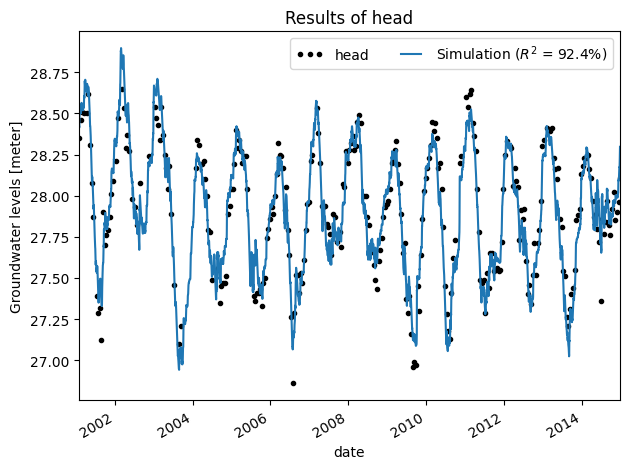

In [7]:
# %%
ml.plot()

## Results

### Parameters

In [8]:
# %%
ml.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
test_mfsm_sy,0.045610,0.001,0.5,True,test_mfsm,NaN,0.003625,0.230878
test_mfsm_c,219.247860,10.000,100000000.0,True,test_mfsm,NaN,60.330928,798.988210
test_mfsm_f,-1.000000,-2.000,0.0,True,test_mfsm,NaN,0.001918,-1.266578
constant_d,27.903864,NaN,NaN,True,constant,uniform,0.019872,27.885359


In [9]:
# %%
mlexp.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
test_exp_A,219.247860,0.00001,21924.786045,True,test_exp,uniform,33.150869,618.818683
test_exp_a,10.000000,0.01000,1000.000000,True,test_exp,uniform,8.115677,183.492840
test_exp_f,-1.000000,-2.00000,0.000000,True,test_exp,uniform,0.063897,-1.618881
constant_d,27.903864,NaN,NaN,True,constant,uniform,0.054914,28.248544


### Plots

<Axes: title={'center': 'Results of head'}, xlabel='date', ylabel='Groundwater levels [meter]'>

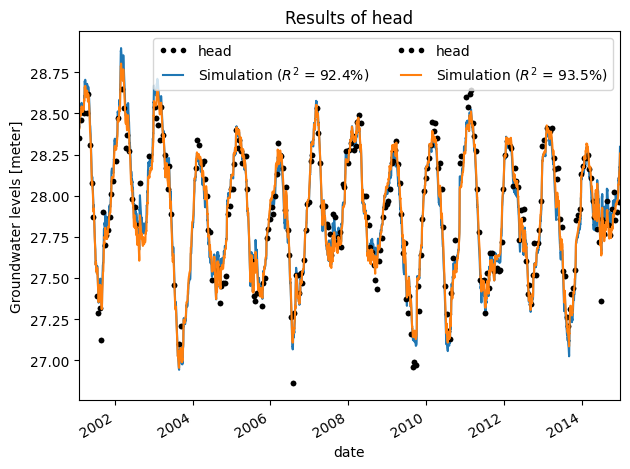

In [10]:
# %%
ax = ml.plot()
mlexp.plot(ax=ax)

<Axes: title={'center': 'Results of head'}, xlabel='date', ylabel='Groundwater levels [meter]'>

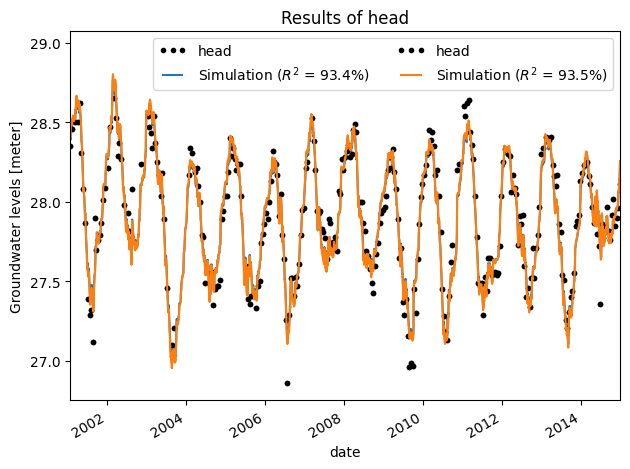

In [11]:
# %%
ax = mlexpmf.plot()
mlexp.plot(ax=ax)